In [4]:
library(tidyverse)
library(caret)
library(randomForest)
library(tree)
library(class)

In [9]:
df_diabetes <- read_csv("dataset_37_diabetes.csv")

summary(df_diabetes)

set.seed(1)
training <-sample(1:nrow(df_diabetes), size = nrow(df_diabetes)*0.5)
testing <- dplyr::setdiff(1:nrow(df_diabetes), training)
diabetesTrain <- df_diabetes[training, ]
diabetesTest <- df_diabetes[testing, ]


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  preg = col_double(),
  plas = col_double(),
  pres = col_double(),
  skin = col_double(),
  insu = col_double(),
  mass = col_double(),
  pedi = col_double(),
  age = col_double(),
  class = col_character()
)




      preg             plas            pres             skin      
 Min.   : 0.000   Min.   :  0.0   Min.   :  0.00   Min.   : 0.00  
 1st Qu.: 1.000   1st Qu.: 99.0   1st Qu.: 62.00   1st Qu.: 0.00  
 Median : 3.000   Median :117.0   Median : 72.00   Median :23.00  
 Mean   : 3.845   Mean   :120.9   Mean   : 69.11   Mean   :20.54  
 3rd Qu.: 6.000   3rd Qu.:140.2   3rd Qu.: 80.00   3rd Qu.:32.00  
 Max.   :17.000   Max.   :199.0   Max.   :122.00   Max.   :99.00  
      insu            mass            pedi             age       
 Min.   :  0.0   Min.   : 0.00   Min.   :0.0780   Min.   :21.00  
 1st Qu.:  0.0   1st Qu.:27.30   1st Qu.:0.2437   1st Qu.:24.00  
 Median : 30.5   Median :32.00   Median :0.3725   Median :29.00  
 Mean   : 79.8   Mean   :31.99   Mean   :0.4719   Mean   :33.24  
 3rd Qu.:127.2   3rd Qu.:36.60   3rd Qu.:0.6262   3rd Qu.:41.00  
 Max.   :846.0   Max.   :67.10   Max.   :2.4200   Max.   :81.00  
    class          
 Length:768        
 Class :character  
 Mode  :c

In [25]:
print(unique(df_diabetes$class))

[1] "tested_positive" "tested_negative"


In [19]:
trctrl <- trainControl(method = "repeatedcv", 
                       number = 10, 
                       repeats = 3)

set.seed(2020)

tree_fit <- train(class ~ ., 
                  data = diabetesTrain, 
                  method = "rpart", 
                  trControl = trctrl, 
                  preProcess = c("center", "scale"),
                  tuneGrid = data.frame(cp = seq(0,0.25,0.01)))

CART 

384 samples
  8 predictor
  2 classes: 'tested_negative', 'tested_positive' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 346, 345, 346, 346, 346, 345, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa      
  0.00  0.6954116  0.327941189
  0.01  0.6997301  0.333808987
  0.02  0.7016194  0.327621477
  0.03  0.7076698  0.324647760
  0.04  0.7207377  0.353196369
  0.05  0.7242465  0.363435804
  0.06  0.7233693  0.363968890
  0.07  0.7163518  0.348706960
  0.08  0.7060279  0.333976511
  0.09  0.7060279  0.333976511
  0.10  0.7060279  0.336037965
  0.11  0.7060279  0.336037965
  0.12  0.7016419  0.329303211
  0.13  0.6964238  0.318847905
  0.14  0.6878543  0.305443367
  0.15  0.6634053  0.207982595
  0.16  0.6530589  0.161214219
  0.17  0.6451642  0.119286233
  0.18  0.6416554  0.092649640
  0.19  0.6399235  0.070285224
  0.20  0.6442420  0.018273037
  0.21  0.6459514  0.0113356

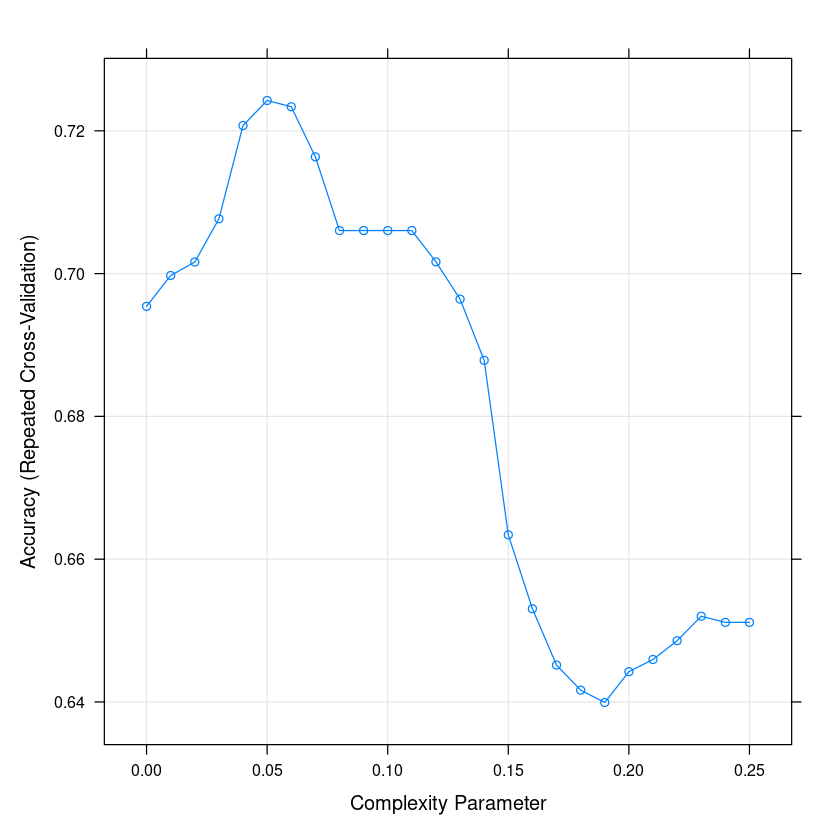

In [20]:
tree_fit
plot(tree_fit)

In [41]:
tree_pred <- predict(tree_fit, newdata = diabetesTest)

tree_misclass <- sum(tree_pred != diabetesTest$class) / nrow(diabetesTest)

print(tree_misclass)

tree_con_tab <- table(tree_pred, diabetesTest$class)

knitr::kable(tree_con_tab)

sum(diag(tree_con_tab))

tree_con_tab[2, 2] / colSums(tree_con_tab)[[2]]

tree_con_tab[2, 1] / colSums(tree_con_tab)[[1]]

# The confusion table shows that the best model misclasses 88 individuals. Specifically, 52 people with 
# diabetes were classed as healthy and 36 healthy individuals were predicted to have diabetes. This model was only able to identify
# 61% of the people with diabetes, and 14% of the healthy individuals might get treatment they don't need.

[1] 0.2291667




|                | tested_negative| tested_positive|
|:---------------|---------------:|---------------:|
|tested_negative |             214|              52|
|tested_positive |              36|              82|

[1] 296

[1] 0.6119403

[1] 0.144

In [48]:
set.seed(2020)

bag_fit <-  train(class ~ ., 
                  data = diabetesTrain, 
                  method = "treebag", 
                  trControl = trctrl, 
                  preProcess = c("center", "scale"))

bag_pred <- predict(bag_fit, newdata = diabetesTest)

In [53]:
bag_misclass <- sum(bag_pred != diabetesTest$class) / nrow(diabetesTest)

sprintf("The bagged tree misclassification rate is %0.3f" , bag_misclass)

bag_con_tab <- table(bag_pred, diabetesTest$class)

knitr::kable(bag_con_tab)

sprintf("The total correct predictions are %d", sum(diag(bag_con_tab)))

sprintf("Fraction false negatives are %0.2f", bag_con_tab[2, 2] / colSums(bag_con_tab)[[2]])

sprintf("Fraction false positives are %0.2f", bag_con_tab[2, 1] / colSums(bag_con_tab)[[1]])

[1] "The bagged tree misclassification rate is 0.266"



|                | tested_negative| tested_positive|
|:---------------|---------------:|---------------:|
|tested_negative |             210|              62|
|tested_positive |              40|              72|

[1] "The total correct predictions are 282"

[1] "Fraction false negatives are 0.54"

[1] "Fraction false positives are 0.16"

In [56]:
set.seed(2020)

rf_fit <-  train(class ~ ., 
                 data = diabetesTrain, 
                 method = "rf", 
                 trControl = trctrl, 
                 preProcess = c("center", "scale"), 
                 tuneGrid = data.frame(mtry = 1:8))

rf_pred <- predict(rf_fit, newdata = diabetesTest)



Random Forest 

384 samples
  8 predictor
  2 classes: 'tested_negative', 'tested_positive' 

Pre-processing: centered (8), scaled (8) 
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 346, 345, 346, 346, 346, 345, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  1     0.7483581  0.4115541
  2     0.7569726  0.4447788
  3     0.7526541  0.4380356
  4     0.7517769  0.4357290
  5     0.7578048  0.4494806
  6     0.7518893  0.4375044
  7     0.7491678  0.4316680
  8     0.7483356  0.4298138

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 5.

[1] "The random forest misclassification rate is 0.250"



|                | tested_negative| tested_positive|
|:---------------|---------------:|---------------:|
|tested_negative |             215|              61|
|tested_positive |              35|              73|

[1] "The total correct predictions are 288"

[1] "Fraction false negatives are 0.54"

[1] "Fraction false positives are 0.14"

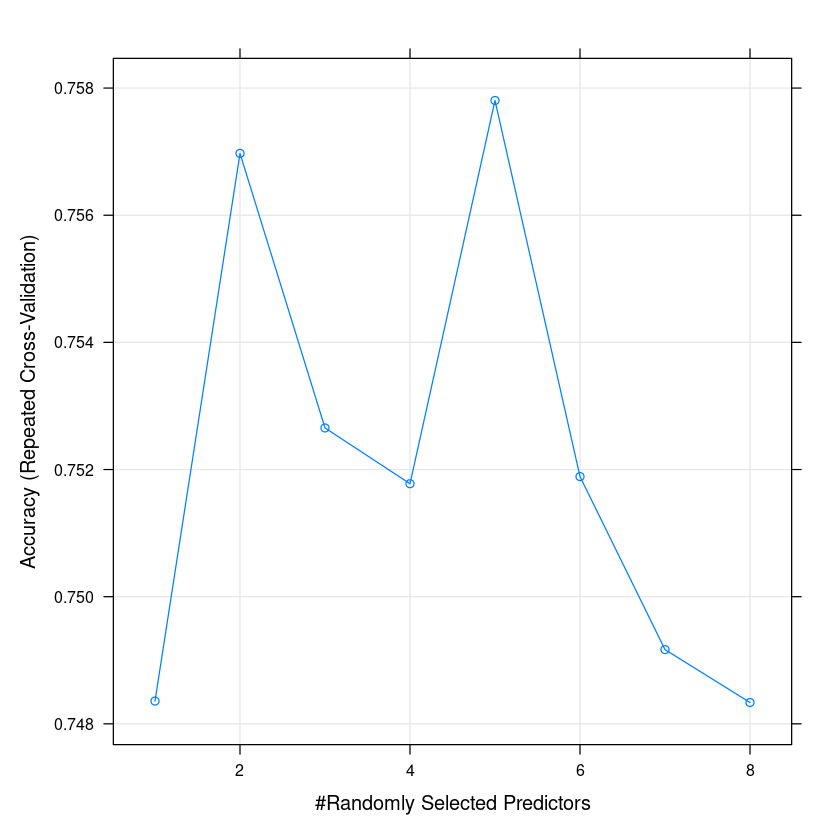

In [60]:
rf_fit
plot(rf_fit)

rf_misclass <- sum(rf_pred != diabetesTest$class) / nrow(diabetesTest)

sprintf("The random forest misclassification rate is %0.3f" , rf_misclass)

rf_con_tab <- table(rf_pred, diabetesTest$class)

knitr::kable(rf_con_tab)

sprintf("The total correct predictions are %d", sum(diag(rf_con_tab)))

sprintf("Fraction false negatives are %0.2f", rf_con_tab[2, 2] / colSums(rf_con_tab)[[2]])

sprintf("Fraction false positives are %0.2f", rf_con_tab[2, 1] / colSums(rf_con_tab)[[1]])

In [61]:
names(rf_fit)

[1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
 [6] "bestTune"     "call"         "dots"         "metric"       "control"     
[11] "finalModel"   "preProcess"   "trainingData" "resample"     "resampledCM" 
[16] "perfNames"    "maximize"     "yLimits"      "times"        "levels"      
[21] "terms"        "coefnames"    "xlevels"

[1] "The random forest misclassification rate is 0.250"



|                | tested_negative| tested_positive|
|:---------------|---------------:|---------------:|
|tested_negative |             216|              55|
|tested_positive |              34|              79|

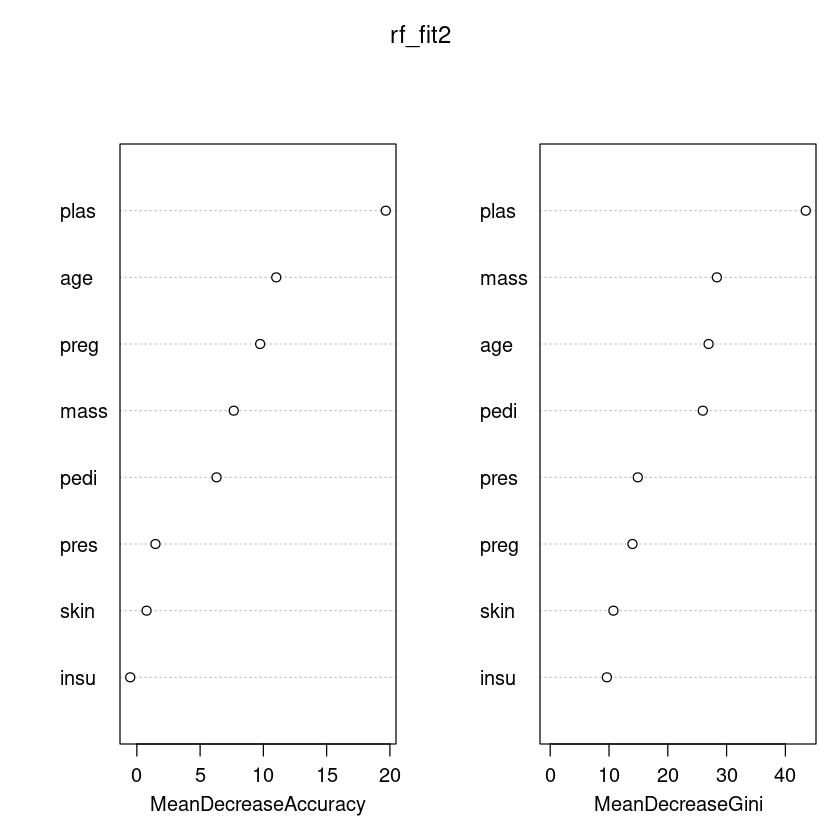

In [84]:
set.seed(2020)

rf_fit2 <- randomForest(as.factor(class) ~ ., data = diabetesTrain, mtry = 5, ntree = 200, importance = TRUE)
varImpPlot(rf_fit2)

rf_pred2 <- predict(rf_fit2, newdata = diabetesTest)

rf_misclass2 <- sum(rf_pred2 != diabetesTest$class) / nrow(diabetesTest)

sprintf("The random forest misclassification rate is %0.3f" , rf_misclass)

rf_con_tab2 <- table(rf_pred2, diabetesTest$class)

knitr::kable(rf_con_tab2)